1. На основе учебного ноутбука, проведите финальную подготовку данных. измените количество сегментирующих классов с `16` на `7`
 - 0_класс - FLOOR
 - 1_класс - CEILING
 - 2_класс - WALL
 - 3_класс - APERTURE, DOOR, WINDOW
 - 4_класс - COLUMN, RAILINGS, LADDER
 - 5_класс - INVENTORY
 - 6_класс - LAMP, WIRE, BEAM, EXTERNAL, BATTERY,
PEOPLE

2. Реализуйте сегментацию базы Стройка на основе модели `PSPnet`. Статья для изучения [Pyramid Scene Parsing Network](https://hszhao.github.io/projects/pspnet/) .


**Важно!**

Многие эксперименты могут приводить к переполнению ОЗУ в вашем ноутбуке и сброса кода обучения.

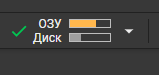


Для предотвращения переполнения ОЗУ может помочь библиотека `gc`. Вставьте строчку `gc.collect()` в цикл ваших экспериментов для сбора и удаления временных данных (кеш).

Перед выполнением задания, пожалуйста, запустите ячейку `Подготовка` ниже:

## Подготовка


### Импорт библиотек

In [ ]:
# Импорты для работы с TensorFlow/Keras
from tensorflow.keras.layers import (
    Activation,
    AveragePooling2D,
    BatchNormalization,
    Concatenate,
    Conv2D,
    Conv2DTranspose,
    Cropping2D,
    Input,
    MaxPooling2D,
    UpSampling2D,
    ZeroPadding2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K

# Импорты для работы с данными
import numpy as np
import os
import zipfile

# Импорты для визуализации
from PIL import Image
import matplotlib.pyplot as plt

# Импорты для загрузки данных
import gdown

# Импорты для управления памятью
import gc

# Импорты для работы со временем
import time

### Загрузка датасета

Функция загрузки датасета

In [2]:
def download_and_extract(url, output_dir):
    """Скачивает и распаковывает архив с датасетом"""
    # Создаем папку для данных, если ее нет
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Путь для сохранения архива
    zip_path = os.path.join(output_dir, 'dataset.zip')
    
    # Скачиваем архив
    print("Скачивание архива...")
    gdown.download(url, zip_path, quiet=False)
    
    # Распаковываем архив
    print("Распаковка архива...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
    
    # Удаляем архив
    os.remove(zip_path)
    print("Датасет готов к использованию")

Распаковка архива, установка глобальных параметры датасета и подготовка данных

In [5]:
# Загрузка и подготовка данных
# Функция загрузки изображений
def load_imageset(folder, subset, title):
    image_list = []
    for filename in sorted(os.listdir(f'{folder}/{subset}')):
        img = image.load_img(os.path.join(f'{folder}/{subset}', filename),
                           target_size=(IMG_HEIGHT, IMG_WIDTH))  # Обратите внимание на порядок размеров!
        image_list.append(img)
    print(f'{title} выборка загружена. Количество изображений:', len(image_list))
    return image_list


# Глобальные параметры
DATASET_URL = 'https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip'
IMG_WIDTH = 256               # Ширина картинки
IMG_HEIGHT = 192              # Высота картинки
NUM_CLASSES = 16              # Задаем количество классов на изображении
DATA_DIR = 'construction_data'
TRAIN_DIRECTORY = os.path.join(DATA_DIR, 'train')    # Название папки с файлами обучающей выборки
VAL_DIRECTORY = os.path.join(DATA_DIR, 'val')         # Название папки с файлами проверочной выборки
# Скачиваем и распаковываем датасет
download_and_extract(DATASET_URL, DATA_DIR)

# Загрузка данных
train_images = load_imageset(TRAIN_DIRECTORY, 'original', 'Обучающая')
val_images = load_imageset(VAL_DIRECTORY, 'original', 'Проверочная')
train_segments = load_imageset(TRAIN_DIRECTORY, 'segment', 'Обучающая сегментированная')
val_segments = load_imageset(VAL_DIRECTORY, 'segment', 'Проверочная сегментированная')

Скачивание архива...


Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip
To: c:\Users\HAIER\Desktop\Задания\Основы нейронных сетей\Занятие 10\nn_lab_10\ДЗ\construction_data\dataset.zip
100%|██████████| 214M/214M [00:33<00:00, 6.29MB/s] 


Распаковка архива...
Датасет готов к использованию
Обучающая выборка загружена. Количество изображений: 1900
Проверочная выборка загружена. Количество изображений: 100
Обучающая сегментированная выборка загружена. Количество изображений: 1900
Проверочная сегментированная выборка загружена. Количество изображений: 100


## Решение

Определение цветов классов и функций преобразования

In [6]:
# Функция преобразования RGB в метки (адаптирована под 7 классов)
def rgb_to_labels(image_list):
    result = []
    for img in image_list:
        sample = np.array(img)
        y = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype='uint8')

        # FLOOR
        y[np.where(np.all(sample == (100, 100, 100), axis=-1))] = 0
        # CEILING
        y[np.where(np.all(sample == (0, 0, 100), axis=-1))] = 1
        # WALL
        y[np.where(np.all(sample == (0, 100, 0), axis=-1))] = 2
        # APERTURE/DOOR/WINDOW
        y[np.where(np.all(sample == (0, 100, 100), axis=-1))] = 3
        y[np.where(np.all(sample == (100, 0, 100), axis=-1))] = 3
        y[np.where(np.all(sample == (100, 100, 0), axis=-1))] = 3
        # COLUMN/RAILINGS/LADDER
        y[np.where(np.all(sample == (100, 0, 0), axis=-1))] = 4
        y[np.where(np.all(sample == (0, 200, 0), axis=-1))] = 4
        y[np.where(np.all(sample == (0, 0, 200), axis=-1))] = 4
        # INVENTORY
        y[np.where(np.all(sample == (200, 0, 200), axis=-1))] = 5
        # LAMP/...
        y[np.where(np.all(sample == (200, 200, 0), axis=-1))] = 6
        y[np.where(np.all(sample == (0, 100, 200), axis=-1))] = 6
        y[np.where(np.all(sample == (100, 0, 200), axis=-1))] = 6
        y[np.where(np.all(sample == (200, 200, 200), axis=-1))] = 6
        y[np.where(np.all(sample == (200, 0, 0), axis=-1))] = 6
        y[np.where(np.all(sample == (0, 200, 200), axis=-1))] = 6

        result.append(y)
    return np.array(result)

def labels_to_rgb(image_list):
    result = []
    for y in image_list:
        temp = np.zeros((y.shape[0], y.shape[1], 3), dtype='uint8')

        # 0 класс - FLOOR
        temp[np.where(y[..., 0] == 0)] = FLOOR
        # 1 класс - CEILING
        temp[np.where(y[..., 0] == 1)] = CEILING
        # 2 класс - WALL
        temp[np.where(y[..., 0] == 2)] = WALL
        # 3 класс - APERTURE/DOOR/WINDOW
        temp[np.where(y[..., 0] == 3)] = APERTURE
        # 4 класс - COLUMN/RAILINGS/LADDER
        temp[np.where(y[..., 0] == 4)] = COLUMN
        # 5 класс - INVENTORY
        temp[np.where(y[..., 0] == 5)] = INVENTORY
        # 6 класс - LAMP/...
        temp[np.where(y[..., 0] == 6)] = LAMP

        result.append(temp)
    return np.array(result)

# Определение цветов классов (7 классов)
FLOOR = (100, 100, 100)         # 0 класс - Пол (серый)
CEILING = (0, 0, 100)           # 1 класс - Потолок (синий)
WALL = (0, 100, 0)              # 2 класс - Стена (зеленый)
APERTURE = (0, 100, 100)        # 3 класс - Проем, Дверь, Окно (объединяем)
COLUMN = (100, 0, 0)            # 4 класс - Колонна, Перила, Лестница (объединяем)
INVENTORY = (200, 0, 200)       # 5 класс - Инвентарь (розовый)
LAMP = (200, 200, 0)            # 6 класс - Лампа, Провод, Балка, Внешний мир, Батареи, Люди (объединяем)

Преобразование данных и проверка форм данных

In [7]:
# Преобразование данных
x_train = np.array([image.img_to_array(img) for img in train_images])
x_val = np.array([image.img_to_array(img) for img in val_images])
y_train = rgb_to_labels(train_segments)
y_val = rgb_to_labels(val_segments)

# Проверка форм данных
print("Форма x_train:", x_train.shape)
print("Форма y_train:", y_train.shape)
print("Форма x_val:", x_val.shape)
print("Форма y_val:", y_val.shape)

Форма x_train: (1900, 192, 256, 3)
Форма y_train: (1900, 192, 256, 1)
Форма x_val: (100, 192, 256, 3)
Форма y_val: (100, 192, 256, 1)


Определение функций для реализации PPM и PSPNet

In [ ]:
def pyramid_pooling_module(input_tensor, bin_sizes):
    """
    Реализует Pyramid Pooling Module (PPM) для PSPNet
    
    Параметры:
        input_tensor - входной тензор
        bin_sizes - список размеров бининга для пирамиды
    """
    concat_list = [input_tensor]
    h, w = K.int_shape(input_tensor)[1], K.int_shape(input_tensor)[2]

    for bin_size in bin_sizes:
        # Рассчитываем размер пула с округлением вверх
        pool_h = (h + bin_size - 1) // bin_size
        pool_w = (w + bin_size - 1) // bin_size

        # Average Pooling
        x = AveragePooling2D((pool_h, pool_w), strides=(pool_h, pool_w), padding='valid')(input_tensor)

        # 1x1 Conv + BatchNorm
        x = Conv2D(512, (1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        # Апсемплинг с коррекцией размера
        x = UpSampling2D(size=(pool_h, pool_w), interpolation='bilinear')(x)

        # Корректировка размеров
        if K.int_shape(x)[1] != h or K.int_shape(x)[2] != w:
            pad_h = max(h - K.int_shape(x)[1], 0)
            pad_w = max(w - K.int_shape(x)[2], 0)
            crop_h = max(K.int_shape(x)[1] - h, 0)
            crop_w = max(K.int_shape(x)[2] - w, 0)

            x = ZeroPadding2D(((0, pad_h), (0, pad_w)))(x)
            x = Cropping2D(((0, crop_h), (0, crop_w)))(x)

        concat_list.append(x)

    return concatenate(concat_list)

def PSPNet(input_shape, n_classes):
    """
    Создает модель PSPNet для семантической сегментации
    
    Параметры:
        input_shape - размер входного изображения (H, W, C)
        n_classes - количество классов сегментации
    """
    inputs = Input(input_shape)

    # Базовая CNN
    x = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = Conv2D(128, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = Conv2D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(512, 3, activation='relu', padding='same')(x)
    x = Conv2D(512, 3, padding='same')(x)
    x = BatchNormalization()(x)

    # Pyramid Pooling
    x = pyramid_pooling_module(x, [1, 2, 3, 6])

    # Финал
    x = Conv2D(512, 3, padding='same', activation='relu')(x)
    x = Conv2D(n_classes, 1)(x)
    x = UpSampling2D(8, interpolation='bilinear')(x)
    outputs = Activation('softmax')(x)

    return Model(inputs, outputs)

Создание модели

In [7]:
# Очистка памяти
del train_images, val_images, train_segments, val_segments
gc.collect()
model = PSPNet((IMG_HEIGHT, IMG_WIDTH, 3), CLASS_COUNT)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 192,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 192,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 192,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 192,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 96,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 96,   │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 96,   │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 96,   │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 48,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 48,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 48,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 48,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 24,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 24,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 24,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 24,    │      2,048 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_2 │ (None, 2, 3, 512) │          0 │ batch_normalizat

 Total params: 17,548,615 (66.94 MB)

 Trainable params: 17,542,599 (66.92 MB)

 Non-trainable params: 6,016 (23.50 KB)

Обучение модели

In [9]:
# Обучение модели
history = model.fit(
    x_train, y_train,
    batch_size=4,
    epochs=50,
    validation_data=(x_val, y_val)
)

Epoch 1/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 68s 144ms/step - accuracy: 0.5855 - loss: 1.2831 - val_accuracy: 0.5333 - val_loss: 1.3681
Epoch 2/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 78s 136ms/step - accuracy: 0.6877 - loss: 0.8982 - val_accuracy: 0.5261 - val_loss: 1.3847
Epoch 3/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 64s 134ms/step - accuracy: 0.7152 - loss: 0.8088 - val_accuracy: 0.5421 - val_loss: 1.2651
Epoch 4/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 83s 137ms/step - accuracy: 0.7283 - loss: 0.7690 - val_accuracy: 0.6072 - val_loss: 1.2002
Epoch 5/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 82s 136ms/step - accuracy: 0.7577 - loss: 0.6936 - val_accuracy: 0.6618 - val_loss: 1.0142
Epoch 6/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 64s 135ms/step - accuracy: 0.7702 - loss: 0.6568 - val_accuracy: 0.6229 - val_loss: 1.1272
Epoch 7/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 82s 136ms/step - accuracy: 0.7811 - loss: 0.6275 - val_accuracy: 0.6085 - val_loss: 1.2425
Epoch 8/50
475/475 ━━━━━━━━━━━━━━━━━━━━ 64s 135ms/step - accuracy: 0.7825 - loss: 0

Сохранение весов модели

In [ ]:
# Сохраняем веса модели
model.save_weights('pspnet.weights.h5')

Визуализация результатов работы модели

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


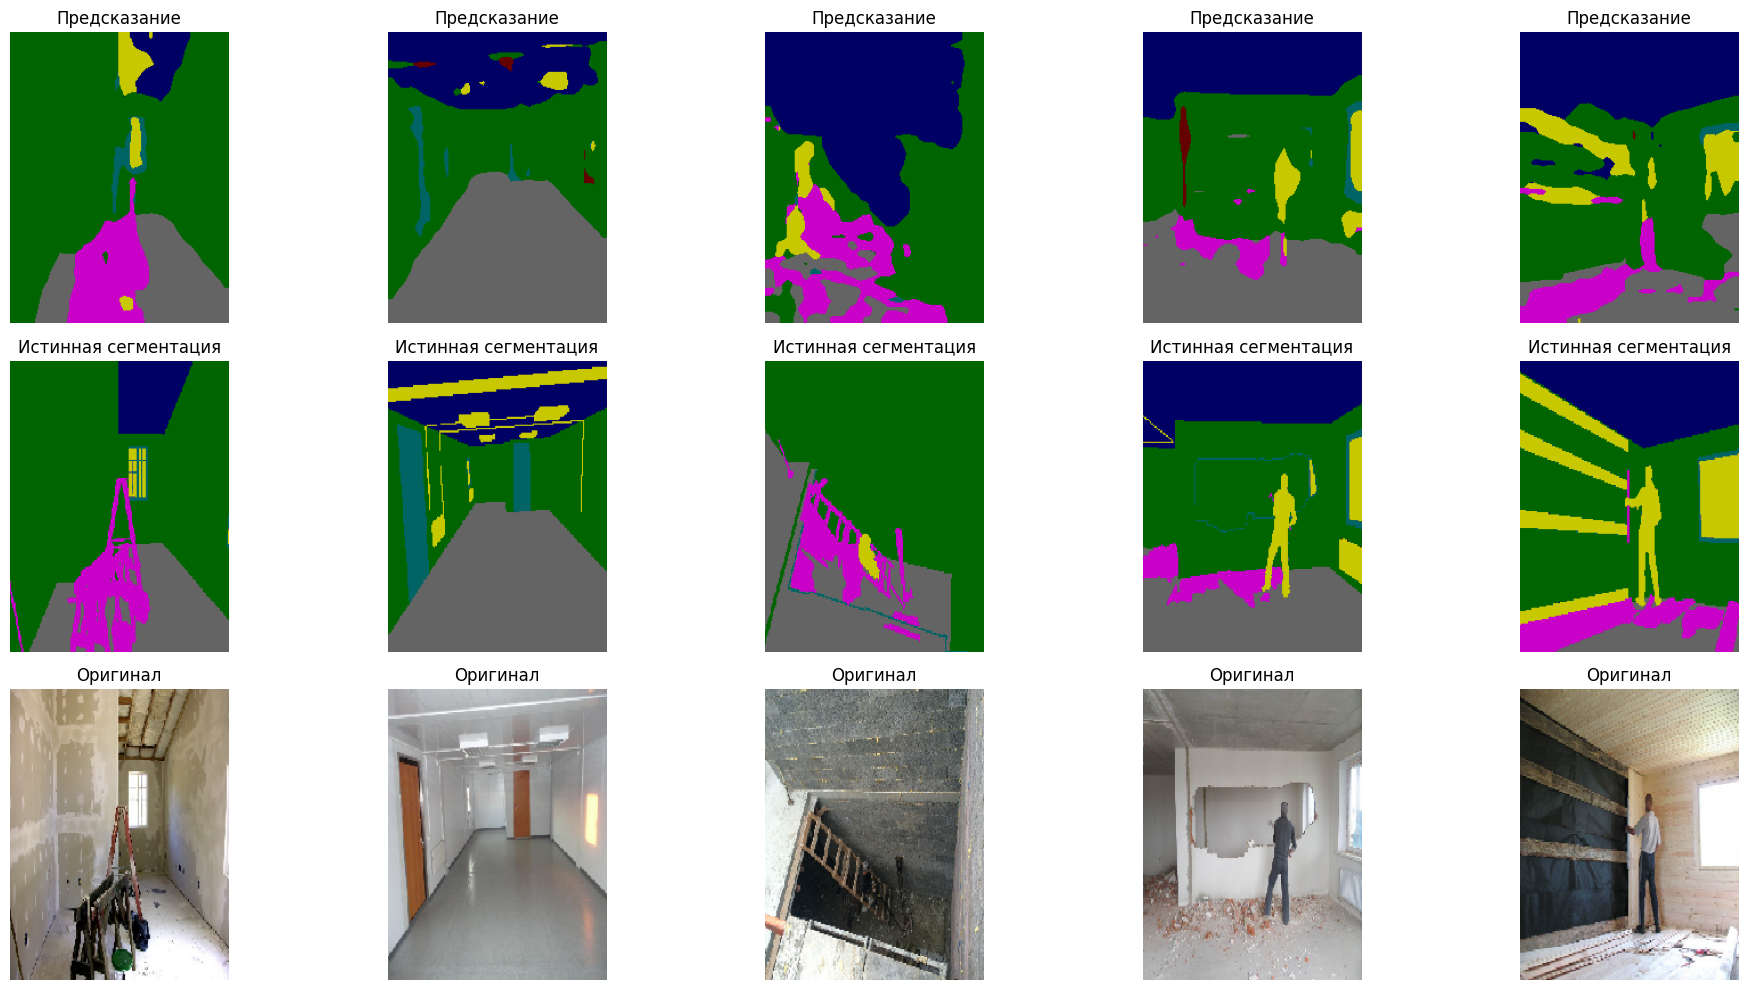

In [ ]:
def process_images(model, count=1):
    """
    Визуализирует результаты сегментации
    
    Параметры:
        model - обученная модель
        count - количество примеров для визуализации
    """
    indexes = np.random.randint(0, len(x_val), count)
    predict = model.predict(x_val[indexes])
    predict_labels = np.argmax(predict, axis=-1)

    pred_rgb = labels_to_rgb(predict_labels[..., np.newaxis])
    val_rgb = labels_to_rgb(y_val[indexes])

    fig, axs = plt.subplots(3, count, figsize=(20, 10))
    if count == 1:
        axs = axs.reshape(3, 1)

    for i in range(count):
        axs[0,i].imshow(pred_rgb[i])
        axs[0,i].set_title('Предсказание')
        axs[0,i].axis('off')

        axs[1,i].imshow(val_rgb[i])
        axs[1,i].set_title('Истинная сегментация')
        axs[1,i].axis('off')

        axs[2,i].imshow(x_val[indexes[i]].astype('uint8'))
        axs[2,i].set_title('Оригинал')
        axs[2,i].axis('off')

    plt.tight_layout()
    plt.show()
# Визуализация результатов
process_images(model, 5)